In [3]:
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import seaborn as sns
import csv
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

In [4]:
# Read the CSV file
# low_memory=False This allows pandas to read the entire file into memory at once, which can help it better infer data types.
# Read the CSV file
df = pd.read_csv('./datasets/electricity_consumption_original.csv', low_memory=False, sep=',', na_values=['?', 'nan', 'NaN', ''])

# Combine 'Date' and 'Time' columns into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('DateTime', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

In [5]:
# Count missing values in each column
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Calculate percentage of missing values
missing_percentage = (missing_values / len(df)) * 100
print("\nPercentage of missing values:")
print(missing_percentage)

# save the missing entries(row) to a csv file
save_missing_entries = df[df.isnull().any(axis=1)]
save_missing_entries.to_csv('missing_entries.csv')


Missing values in each column:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Percentage of missing values:
Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64


In [6]:
# Identify missing data
missing_data = df[df.isnull().any(axis=1)]

# Create a DataFrame with missing data information
missing_info = pd.DataFrame({
    'Missing_Index': missing_data.index,
    'Missing_Column': missing_data.apply(lambda row: ', '.join(row.index[row.isnull()]), axis=1),
    'Day_of_Week': missing_data.index.day_name(),
    'Month': missing_data.index.month_name(),
    'Year': missing_data.index.year,
    'Hour': missing_data.index.hour
})

# Print summary of missing data
print(f"Total number of missing values: {len(missing_info)}")
print(f"Percentage of missing values: {(len(missing_info) / len(df)) * 100:.2f}%")

# Display distribution of missing values
print("\nDistribution of missing values:")
print(missing_info['Day_of_Week'].value_counts().sort_index())
print("\n", missing_info['Month'].value_counts().sort_index())
print("\n", missing_info['Year'].value_counts().sort_index())
print("\n", missing_info['Missing_Column'].value_counts())

Total number of missing values: 25979
Percentage of missing values: 1.25%

Distribution of missing values:
Day_of_Week
Friday       1450
Monday       2772
Saturday     6773
Sunday       6611
Thursday     3482
Tuesday      1910
Wednesday    2981
Name: count, dtype: int64

 Month
April        3726
August       8141
December       78
February       71
January      3135
July          138
June         3351
March        2031
May             7
November       12
October        47
September    5242
Name: count, dtype: int64

 Year
2006        4
2007     3931
2008      135
2009     4280
2010    17629
Name: count, dtype: int64

 Missing_Column
Global_active_power, Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3    25979
Name: count, dtype: int64


In [7]:
def identify_gaps_and_missing(df, gap_threshold=10):
    # Ensure the index is sorted
    df = df.sort_index()

    # Initialize lists to store missing ranges and time gaps
    missing_ranges = []
    gap_ranges = []
    start = None
    prev_idx = None

    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        # Check if the entire row is missing
        if row.isnull().all():
            if start is None:
                start = idx
        elif start is not None:
            # End of a missing range
            missing_ranges.append((start, idx - pd.Timedelta(minutes=1)))
            start = None

        # Check for time gaps between consecutive rows
        if prev_idx is not None and (idx - prev_idx) > pd.Timedelta(minutes=1):
            gap_ranges.append((prev_idx, idx))

        prev_idx = idx

    # Handle the case where the last row is missing
    if start is not None:
        missing_ranges.append((start, df.index[-1]))

    # Create a summary DataFrame for gaps and missing ranges
    gap_summary = [
        {
            'start_time': start,
            'end_time': end,
            'duration': (end - start) + pd.Timedelta(minutes=1),
            'gap_type': 'small' if (end - start) + pd.Timedelta(minutes=1) <= pd.Timedelta(minutes=gap_threshold) else 'large'
        }
        for start, end in missing_ranges + gap_ranges
    ]

    # Convert the summary list to a DataFrame and sort by start time
    gap_summary = pd.DataFrame(gap_summary).sort_values('start_time').reset_index(drop=True)

    return gap_summary

def find_largest_continuous_range(df, gap_summary):
    # Combine small gaps with data
    data_ranges = []
    start = df.index[0]
    for _, gap in gap_summary.iterrows():
        if gap['gap_type'] == 'large':
            data_ranges.append((start, gap['start_time']))
            start = gap['end_time']
    data_ranges.append((start, df.index[-1]))

    # Find the largest range
    df_largest_range = max(data_ranges, key=lambda x: x[1] - x[0])

    return df_largest_range

# Use the function to identify gaps and missing data
gap_threshold = 10
gap_summary = identify_gaps_and_missing(df, gap_threshold=gap_threshold)

# Save the gap summary to a CSV file
gap_summary.to_csv('./datasets/results/gap_summary.csv', index=False)

# Print the results
print("Gap Summary:")
print(gap_summary)

# Print additional statistics
print(f"\nTotal number of gaps: {len(gap_summary)}")
print(f"Number of small gaps: {len(gap_summary[gap_summary['gap_type'] == 'small'])}")
print(f"Number of large gaps: {len(gap_summary[gap_summary['gap_type'] == 'large'])}")
print(f"Largest gap duration: {gap_summary['duration'].max()}")
print(f"Total duration of gaps: {gap_summary['duration'].sum()}")

Gap Summary:
            start_time            end_time        duration gap_type
0  2006-12-21 11:23:00 2006-12-21 11:24:00 0 days 00:02:00    small
1  2006-12-30 10:08:00 2006-12-30 10:09:00 0 days 00:02:00    small
2  2007-01-14 18:36:00 2007-01-14 18:36:00 0 days 00:01:00    small
3  2007-01-28 17:13:00 2007-01-28 17:13:00 0 days 00:01:00    small
4  2007-02-22 22:58:00 2007-02-22 22:59:00 0 days 00:02:00    small
..                 ...                 ...             ...      ...
66 2010-06-29 16:53:00 2010-06-29 16:53:00 0 days 00:01:00    small
67 2010-07-15 14:33:00 2010-07-15 14:33:00 0 days 00:01:00    small
68 2010-08-17 21:02:00 2010-08-22 21:27:00 5 days 00:26:00    large
69 2010-09-25 03:56:00 2010-09-28 19:12:00 3 days 15:17:00    large
70 2010-10-24 15:35:00 2010-10-24 15:35:00 0 days 00:01:00    small

[71 rows x 4 columns]

Total number of gaps: 71
Number of small gaps: 56
Number of large gaps: 15
Largest gap duration: 5 days 00:26:00
Total duration of gaps: 18 days 00

Largest continuous range without large gaps:
Start date: 2007-08-01 08:32:00
End date: 2008-10-25 10:28:00
Duration: 451 days 01:56:00


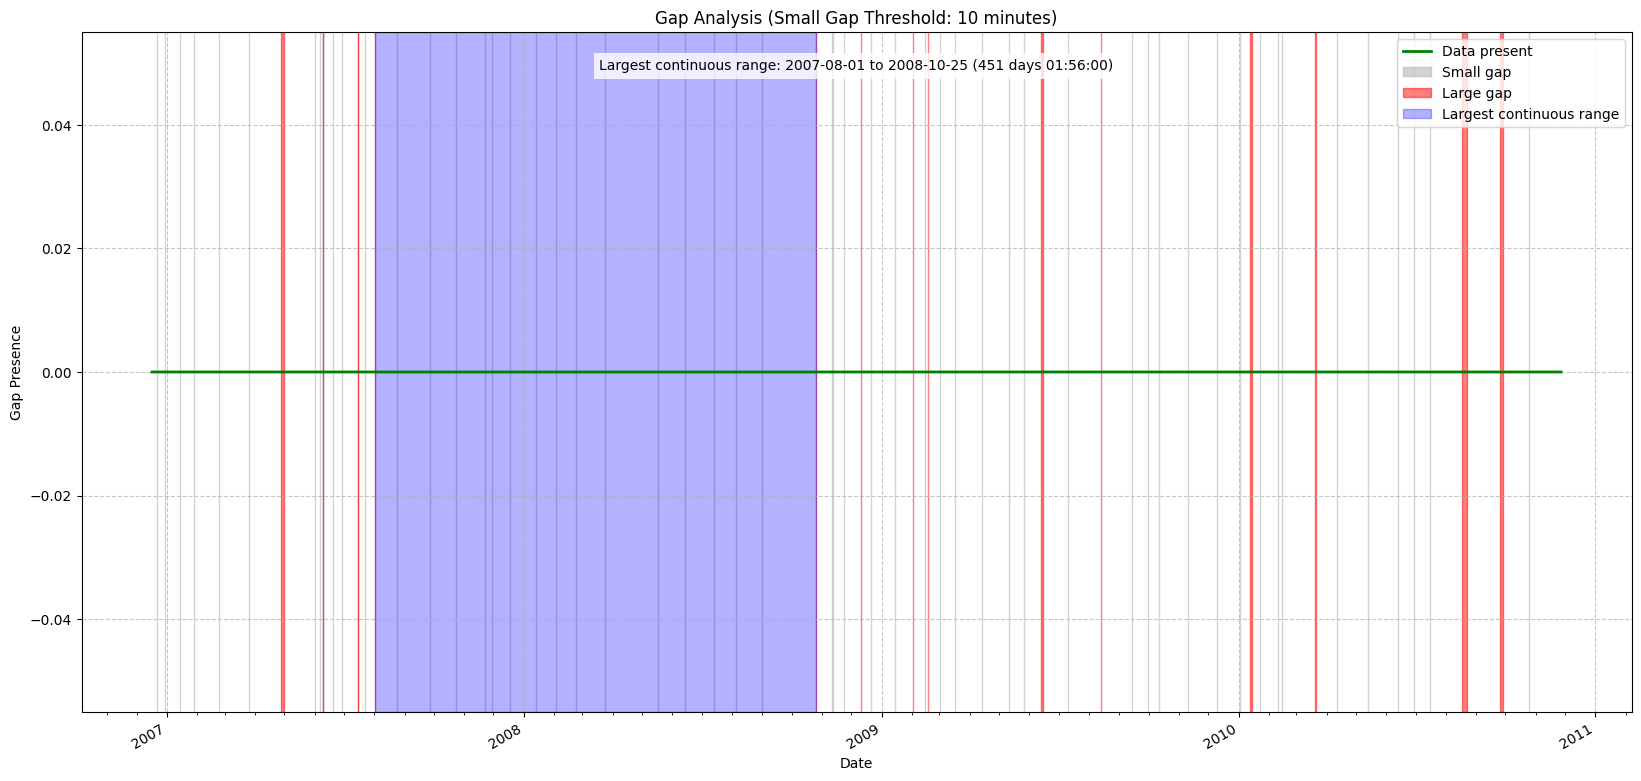

In [8]:
# Find the largest continuous range without large gaps
df_largest_range = find_largest_continuous_range(df, gap_summary)

# save the largest continuous range to a csv file
df.loc[df_largest_range[0]:df_largest_range[1]].iloc[1:-1].to_csv('./datasets/results/largest_continuous_range.csv')

print(f"Largest continuous range without large gaps:")
print(f"Start date: {df_largest_range[0]}")
print(f"End date: {df_largest_range[1]}")
print(f"Duration: {df_largest_range[1] - df_largest_range[0]}")

def plot_gap_analysis(df, gap_summary, gap_threshold, df_largest_range):
    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot the full date range
    ax.plot(df.index, [0]*len(df), color='green', linewidth=2, label='Data present')

    # Plot gaps
    for _, gap in gap_summary.iterrows():
        color = '#A9A9A9' if gap['gap_type'] == 'small' else 'red'
        ax.axvspan(gap['start_time'], gap['end_time'], color=color, alpha=0.5, label=gap['gap_type'].capitalize() + ' gap')

    # Plot largest continuous range
    ax.axvspan(df_largest_range[0], df_largest_range[1], color='blue', alpha=0.3, label='Largest continuous range')

    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Gap Presence')
    ax.set_title(f'Gap Analysis (Small Gap Threshold: {gap_threshold} minutes)')

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add text for largest continuous range
    range_duration = df_largest_range[1] - df_largest_range[0]
    ax.text(0.5, 0.95, f'Largest continuous range: {df_largest_range[0].date()} to {df_largest_range[1].date()} ({range_duration})',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # Save and show the plot
    plt.savefig(f'gap_analysis_gap_threshold_{gap_threshold}.png', dpi=600, bbox_inches='tight')
    plt.show()


plot_gap_analysis(df, gap_summary, gap_threshold, df_largest_range)

In [9]:
import pandas as pd
import numpy as np

# Load the dataset
new_df_lg_df = pd.read_csv('./datasets/results/largest_continuous_range.csv', low_memory=False, sep=',', na_values=['?', 'nan', 'NaN', ''])

# Convert DateTime column to datetime object
new_df_lg_df['DateTime'] = pd.to_datetime(new_df_lg_df['DateTime'])

# Set DateTime as the index
new_df_lg_df.set_index('DateTime', inplace=True)

# Resample the data to a 1-minute frequency
resampled_df = new_df_lg_df.resample('1min').asfreq()

# Apply linear interpolation for gaps under 5 minutes
linear_interpolated_df = resampled_df.interpolate(method='linear', limit=4)

# Apply spline interpolation for gaps between 5 and 10 minutes
final_interpolated_df = linear_interpolated_df.interpolate(method='spline', order=3, limit=10)

# Display the head of the final interpolated dataframe
final_interpolated_df.to_csv('./datasets/results/final_interpolated_df.csv')

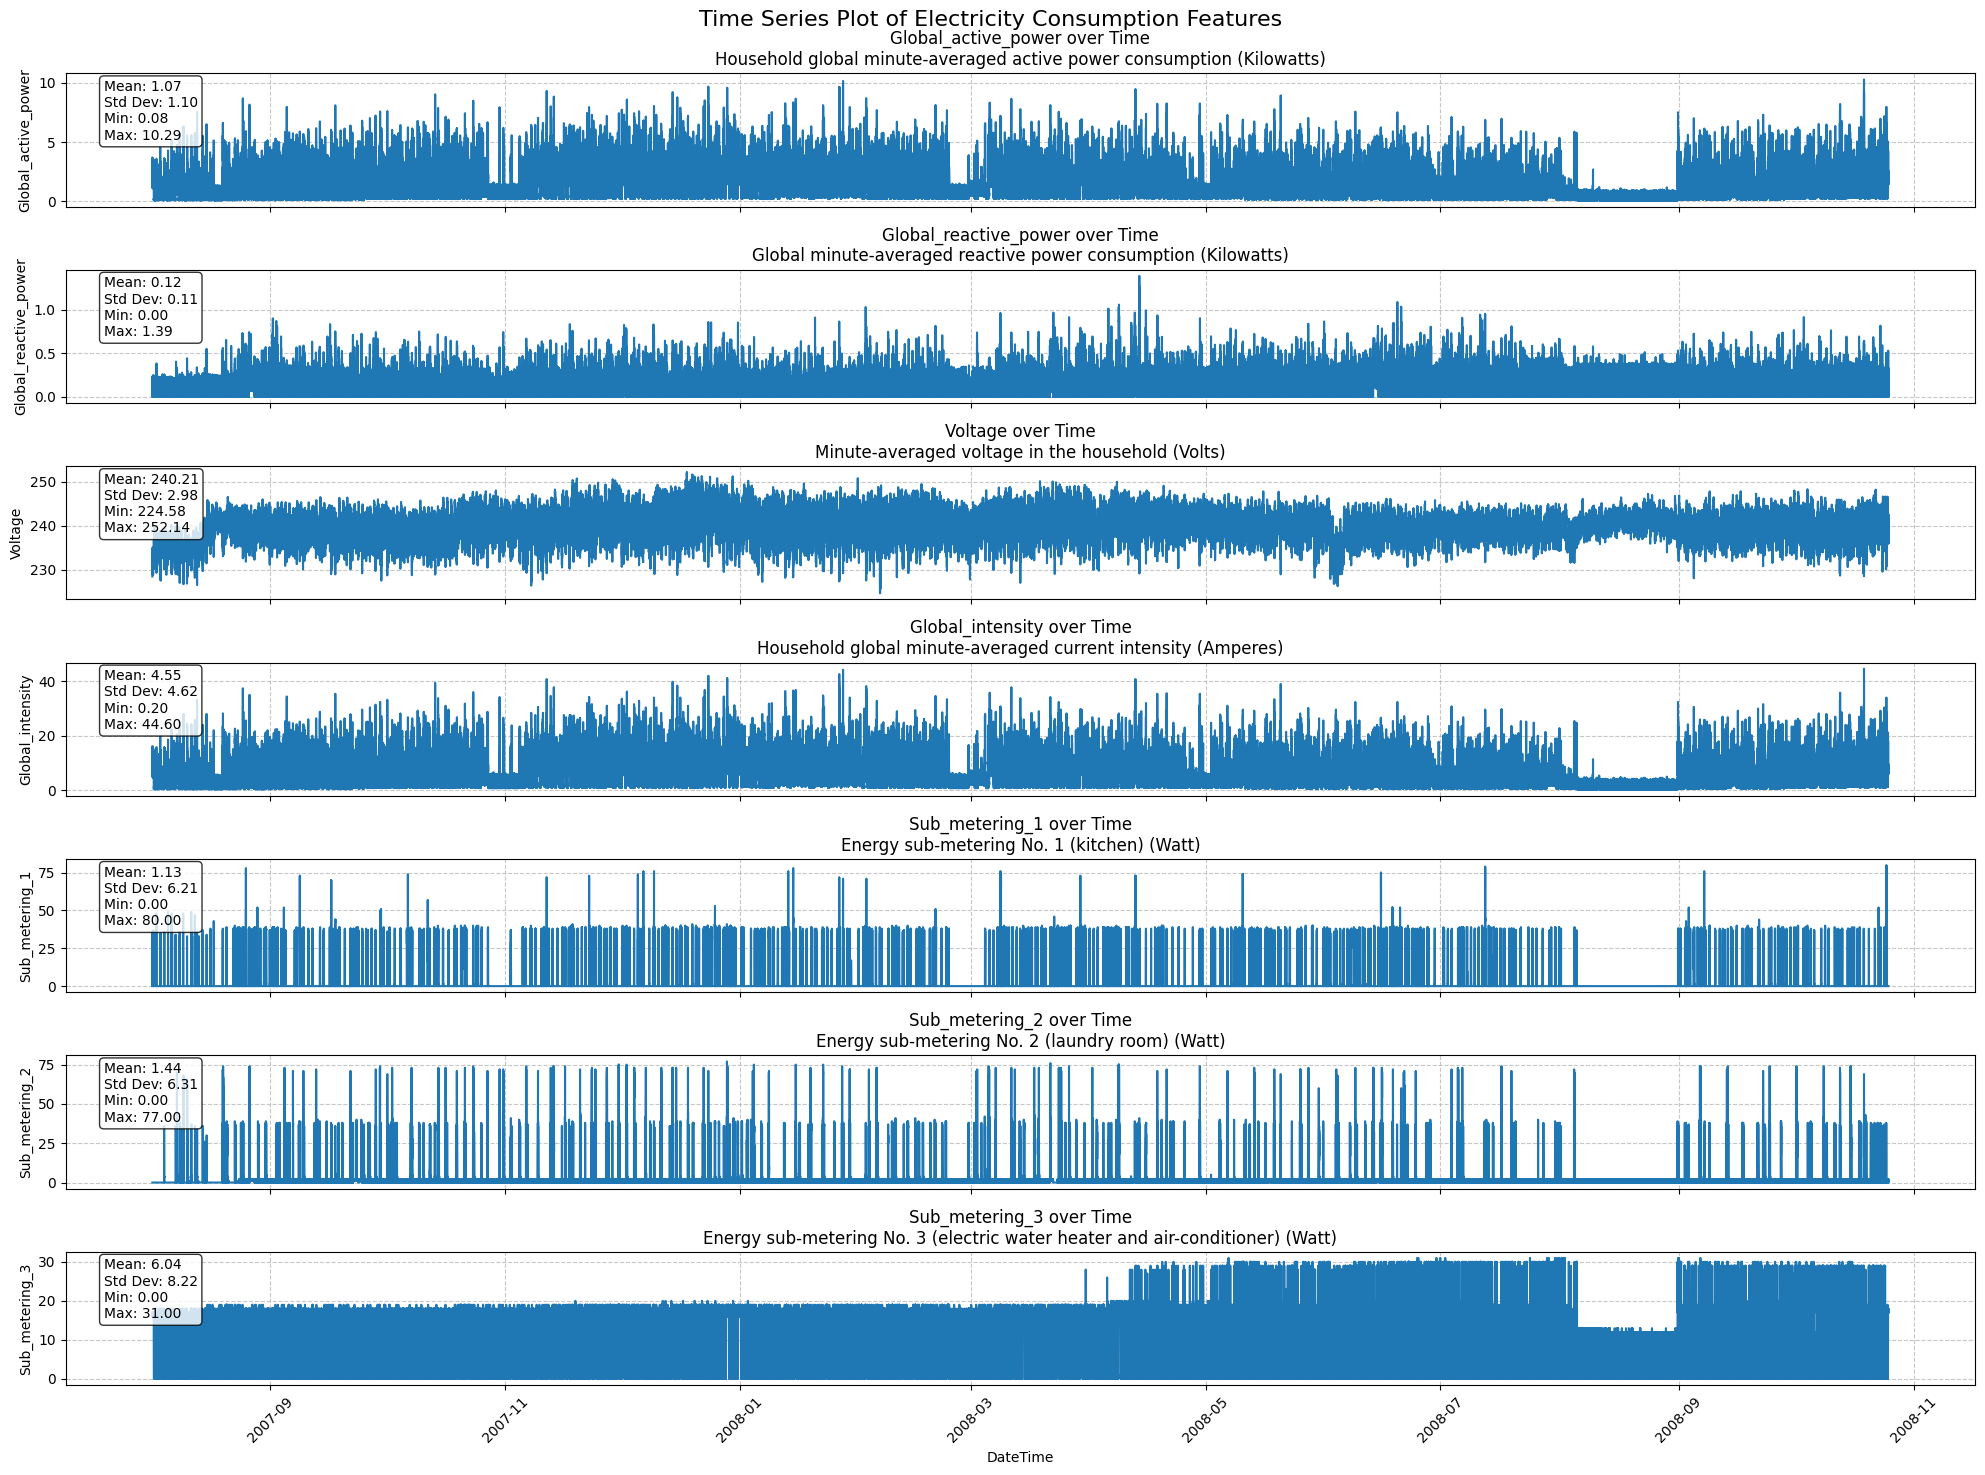

In [10]:
def plot_time_series(df, features, figsize=(20, 15)):
    """
    Plot time series data for multiple features.
    
    Parameters:
    df (DataFrame): The DataFrame containing the time series data
    features (list): List of column names to plot
    figsize (tuple): Figure size (width, height)
    """
    # Feature descriptions
    feature_info = {
        'Global_active_power': 'Household global minute-averaged active power consumption (Kilowatts)',
        'Global_reactive_power': 'Global minute-averaged reactive power consumption (Kilowatts)',
        'Voltage': 'Minute-averaged voltage in the household (Volts)',
        'Global_intensity': 'Household global minute-averaged current intensity (Amperes)',
        'Sub_metering_1': 'Energy sub-metering No. 1 (kitchen) (Watt)',
        'Sub_metering_2': 'Energy sub-metering No. 2 (laundry room) (Watt)',
        'Sub_metering_3': 'Energy sub-metering No. 3 (electric water heater and air-conditioner) (Watt)'
    }

    # Set up the plot
    fig, axes = plt.subplots(len(features), 1, figsize=figsize, sharex=True)
    fig.suptitle(
        'Time Series Plot of Electricity Consumption Features', fontsize=16)

    # Plot each feature
    for i, feature in enumerate(features):
        ax = axes[i] if len(features) > 1 else axes

        # Plot the data
        sns.lineplot(x=df.index, y=df[feature], ax=ax)

        # Set labels and title
        ax.set_ylabel(feature)
        ax.set_title(f'{feature} over Time\n{feature_info.get(feature, "")}')

        # Rotate x-axis labels for better readability
        ax.tick_params(axis='x', rotation=45)

        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)

        # Add some statistics as text
        stats_text = f"Mean: {df[feature].mean():.2f}\n"
        stats_text += f"Std Dev: {df[feature].std():.2f}\n"
        stats_text += f"Min: {df[feature].min():.2f}\n"
        stats_text += f"Max: {df[feature].max():.2f}"
        ax.text(0.02, 0.95, stats_text, transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# List of features to plot
features_to_plot = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Create the plot
plot_time_series(final_interpolated_df, features_to_plot)